<a href="https://colab.research.google.com/github/mnslarcher/cs224w-slides-to-code/blob/main/notebooks/03-node-embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
    # Check if Karate Club is installed:
    import karateclub
except ImportError:
    # If Karate Club is not installed, install it.
    %pip install karateclub==1.2.1

     |████████████████████████████████| 59 kB 2.8 MB/s 
     |████████████████████████████████| 1.8 MB 18.5 MB/s 
     |████████████████████████████████| 24.1 MB 1.8 MB/s 
  Created wheel for karateclub: filename=karateclub-1.2.1-py3-none-any.whl size=94671 sha256=bfd35360dc58bb33c3ae0da5d118f66fc4eb7311999a8ae6c5af5c1bb3fce8fb
  Stored in directory: /root/.cache/pip/wheels/70/d3/49/b058bfc660537177cefe9bd1f53de94e9762bd1c5ef668a523
Successfully built karateclub
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


# Node Embeddings

In [2]:
import random
import time
from typing import Optional, Tuple, Union

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from IPython.display import clear_output, display

In [3]:
def seed_everything(seed: Optional[int] = None) -> None:
    random.seed(seed)
    np.random.seed(seed)


seed_everything(42)

# Random Walk

In [4]:
class RandomWalk:
    def __init__(
        self,
        G: nx.Graph,
        node_size: int = 1500,
        width: int = 2,
        font_size: int = 16,
        fig_size: Tuple[int, int] = (8, 6),
        seed: Optional[int] = 42,
    ) -> None:
        self.G = G
        self.node_size = node_size
        self.width = width
        self.font_size = font_size
        self.fig_size = fig_size
        self.seed = seed

    def _draw(self, ax: plt.Axes) -> None:
        node_colors = [
            "tab:blue"
            if node == self.current_node
            else "tab:orange"
            if node == self.starting_node
            else "tab:gray"
            if node in self.visited_nodes
            else "white"
            for node in self.G.nodes
        ]
        edge_colors = ["tab:gray" if sorted(edge) in self.visited_edges else "black" for edge in self.G.edges]
        pos = nx.spring_layout(self.G, seed=self.seed)

        nx.draw(
            self.G,
            pos=pos,
            ax=ax,
            node_color=node_colors,
            edgecolors="black",
            edge_color=edge_colors,
            node_size=self.node_size,
            width=self.width,
            font_size=self.font_size,
            with_labels=True,
        )

    def run(self, num_steps: int = 5, sleep_seconds: float = 0.5) -> None:
        self.starting_node = random.choice(list(self.G.nodes))
        self.current_node = self.starting_node
        self.visited_nodes = [self.current_node]
        self.visited_edges = []
        title = f"Random walk ({num_steps} steps): {self.current_node}"

        fig = plt.gcf()
        ax = fig.gca()
        self._draw(ax)
        plt.title(title, fontsize=self.font_size, loc="left")
        display(fig)
        clear_output(wait=True)

        for _ in range(num_steps):
            previous_node = self.current_node
            self.current_node = random.choice(list(self.G.neighbors(previous_node)))
            self.visited_edges.append(sorted((previous_node, self.current_node)))
            self.visited_nodes.append(self.current_node)
            title += f" -> {self.current_node}"

            time.sleep(sleep_seconds)
            self._draw(ax)
            plt.title(title, fontsize=self.font_size, loc="left")
            display(fig)
            clear_output(wait=True)

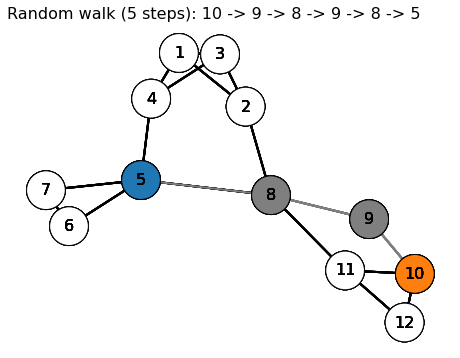

In [5]:
edge_list = [
    (1, 2),
    (1, 3),
    (1, 4),
    (2, 3),
    (2, 8),
    (3, 4),
    (4, 5),
    (5, 6),
    (5, 7),
    (5, 8),
    (6, 7),
    (8, 9),
    (8, 11),
    (9, 10),
    (10, 11),
    (10, 12),
    (11, 12),
]
G = nx.Graph(edge_list)
random_walk = RandomWalk(G)

plt.figure(figsize=(8, 6))
random_walk.run()
plt.show()

# How should we randomly walk?

In [6]:
from karateclub import Estimator
from sklearn.cluster import KMeans

In [7]:
def node_embedding_method_example(
    G: nx.Graph, model: Estimator, n_clusters: int = 4, node_size: int = 500, font_size=16, seed: Optional[int] = 42
) -> None:
    model.fit(G.copy())
    embeddings = model.get_embedding()
    labels = KMeans(n_clusters,random_state=seed).fit_predict(embeddings)

    pos = nx.spring_layout(G, seed=seed)
    cmap = plt.get_cmap("tab10")
    node_colors = [cmap(label) for label in labels]

    nx.draw(G, pos=pos, node_color=node_colors, node_size=node_size, with_labels=True)
    plt.title(
        f"Colored nodes based on clusters identified by K-Means (K={n_clusters})\n on embeddings extracted with "
        f"{type(model).__name__}",
        fontsize=font_size,
    )

In [8]:
G = nx.karate_club_graph()

## DeepWalk

In [9]:
from karateclub import DeepWalk

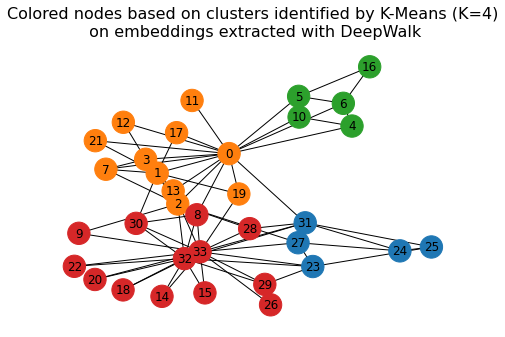

In [10]:
node_embedding_method_example(G, DeepWalk(dimensions=16))

## Node2Vec

In [11]:
from karateclub import Node2Vec

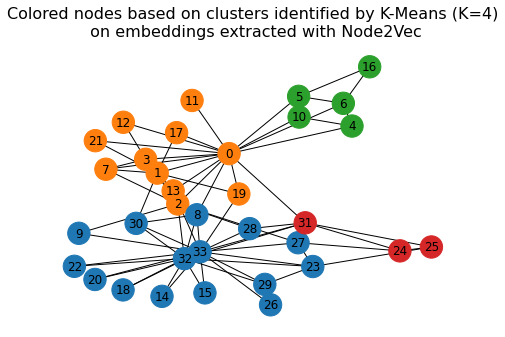

In [12]:
node_embedding_method_example(G, Node2Vec(dimensions=16))

# Embedding Entire Graphs

> The following part is an adaptation of a [tutorial](https://karateclub.readthedocs.io/en/latest/notes/introduction.html#graph-embedding) from the [Karate Club](https://karateclub.readthedocs.io/en/latest/index.html#) library

In [13]:
from karateclub.dataset import GraphSetReader
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

In [14]:
def split_and_fit_logistic_and_print_aoc(
    X: np.ndarray, y: np.ndarray, test_size: Union[int, float] = 0.2, seed: Optional[int] = 42
) -> None:
    print("Splitting the data:")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
    print(
        f"- X_train shape: {X_train.shape}\n- X_test shape: {X_test.shape}"
        f"\n- y_train shape: {y_train.shape}\n- y_test shape: {y_test.shape}"
    )

    print("\nFitting a logistic regression")
    downstream_model = LogisticRegression(random_state=seed).fit(X_train, y_train)
    y_hat = downstream_model.predict_proba(X_test)[:, 1]

    auc = roc_auc_score(y_test, y_hat)
    print(f"\nArea Under the ROC curve (AUC): {auc:.4f}")

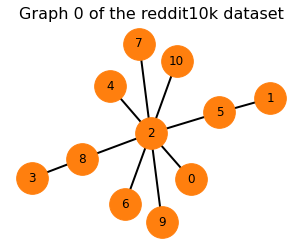

In [15]:
# The task is the classification of threads from the online forum Reddit. The threads can be of of two types -
# discussion and non-discussion based ones. Our goal is to predict the type of the thread based on the topological
# (structural) properties of the graphs. The specific dataset that we look a 10 thousand graph subsample of the Reddit
# 204K dataset which contains a large number of threads from the spring of 2018. The graphs in the dataset do not have
# a specific feature.

reader = GraphSetReader("reddit10k")

graphs = reader.get_graphs()[:1000]
y = reader.get_target()[:1000]

plt.figure(figsize=(4, 3))
nx.draw(graphs[0], node_color="tab:orange", node_size=1000, width=2, with_labels=True)
plt.title("Graph 0 of the reddit10k dataset", fontsize=16)
plt.show()

# Approach 1

In [16]:
def get_graph_embedding(G: nx.Graph, model: Estimator) -> np.ndarray:
    model.fit(G.copy())
    return model.get_embedding().sum(0)

In [17]:
print('Computing the graph embedding for each graph in the dataset using the "sum" approach')
X = np.vstack([get_graph_embedding(G, DeepWalk(dimensions=16))for G in tqdm(graphs)])

split_and_fit_logistic_and_print_aoc(X, y)

Computing the graph embedding for each graph in the dataset using the "sum" approach


  0%|          | 0/1000 [00:00<?, ?it/s]

Splitting the data:
- X_train shape: (800, 16)
- X_test shape: (200, 16)
- y_train shape: (800,)
- y_test shape: (200,)

Fitting a logistic regression

Area Under the ROC curve (AUC): 0.6500


# Approach 2

In [18]:
def get_graph_embedding(G: nx.Graph, model: Estimator) -> np.ndarray:
    G = G.copy()
    nodes = list(G.nodes())
    virtual_node = max(nodes) + 1
    G.add_node(virtual_node)
    G.add_edges_from([(virtual_node, node) for node in nodes])
    model.fit(G)
    return model.get_embedding()[-1]

In [19]:
print('Computing the graph embedding for each graph in the dataset using the "virtual node" approach')
X = np.vstack([get_graph_embedding(G, DeepWalk(dimensions=16))for G in tqdm(graphs)])

split_and_fit_logistic_and_print_aoc(X, y)

Computing the graph embedding for each graph in the dataset using the "virtual node" approach


  0%|          | 0/1000 [00:00<?, ?it/s]

Splitting the data:
- X_train shape: (800, 16)
- X_test shape: (200, 16)
- y_train shape: (800,)
- y_test shape: (200,)

Fitting a logistic regression

Area Under the ROC curve (AUC): 0.7063


# Approach 3

In [20]:
!git clone https://github.com/nd7141/AWE.git

%cd AWE

!git checkout fc4d3c4d180e5793d6cd4ba9235889067039d038

from AnonymousWalkKernel import AnonymousWalks

%cd ..
%rm -rf AWE

Cloning into 'AWE'...
remote: Enumerating objects: 515, done.
remote: Total 515 (delta 0), reused 0 (delta 0), pack-reused 515
Receiving objects: 100% (515/515), 2.38 MiB | 7.13 MiB/s, done.
Resolving deltas: 100% (338/338), done.
/content/AWE
Note: checking out 'fc4d3c4d180e5793d6cd4ba9235889067039d038'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at fc4d3c4 Fix setup for FB parameters
/content


In [21]:
def get_graph_embedding(G: nx.Graph, num_steps: int = 3) -> np.ndarray:
    embedding = AnonymousWalks(G=G).embed(steps=num_steps, verbose=False)[0]
    return np.asarray(embedding)

In [22]:
print('Computing the graph embedding for each graph in the dataset using the "Anonymous Walk" approach')
X = np.vstack([get_graph_embedding(G)for G in tqdm(graphs)])

split_and_fit_logistic_and_print_aoc(X, y)

Computing the graph embedding for each graph in the dataset using the "Anonymous Walk" approach


  0%|          | 0/1000 [00:00<?, ?it/s]

Splitting the data:
- X_train shape: (800, 7)
- X_test shape: (200, 7)
- y_train shape: (800,)
- y_test shape: (200,)

Fitting a logistic regression

Area Under the ROC curve (AUC): 0.7830
